In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sn
import re
import nltk
nltk.download('stopwords')  # Download text data sets, including stop words
from nltk.corpus import stopwords # Import the stop word list
stops=stopwords.words('english')
import matplotlib.cm as cm
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/weiding/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df_sum_all = pd.read_csv("/Users/weiding/projects/application_project_nlp_company_description/company_tab_content_sum_all_with_label.csv")

In [3]:
df_sum_all.head(5)

,Web,tab,content,IndustrySegment,IndustryCode,IndustrySubcode
0,3playmedia.com,3pla_#,"34 Farnsworth Street 4th Floor Boston, MA 0221...","Business Support Services, Software","Business Support Services: Other, Multimedia /...",
1,3playmedia.com,3pla_company_,"Find out the history, mission, and vision of o...","Business Support Services, Software","Business Support Services: Other, Multimedia /...",
2,3playmedia.com,3pla_company_about-3play-media_,"We provide premium closed captioning, transcri...","Business Support Services, Software","Business Support Services: Other, Multimedia /...",
3,3playmedia.com,3pla_company_contact-us_,"MktoForms2.loadForm(""//web.archive.org/web/201...","Business Support Services, Software","Business Support Services: Other, Multimedia /...",
4,3playmedia.com,3pla_company_jobs_,Thanks for your interest in working with us..3...,"Business Support Services, Software","Business Support Services: Other, Multimedia /...",


In [4]:
df_upper_category = pd.read_excel('/Users/weiding/Documents/Application Project Large Files/LargeCategory.xlsx',header=None)
df_upper_category.columns = ['IndustrySegment', 'Category']
df_upper_category

,IndustrySegment,Category
0,Business Support Services,BUSINESS & FINANCIAL SERVICES
1,Construction and Civil Engineering,BUSINESS & FINANCIAL SERVICES
2,Financial Institutions and Services,BUSINESS & FINANCIAL SERVICES
3,Wholesale Trade and Shipping,BUSINESS & FINANCIAL SERVICES
4,Food and Beverage,CONSUMER GOODS GROUP
5,Household and Office Goods,CONSUMER GOODS GROUP
6,Personal Goods,CONSUMER GOODS GROUP
7,Vehicles and Parts,CONSUMER GOODS GROUP
8,Media and Content,CONSUMER SERVICES GROUP
9,Retailers,CONSUMER SERVICES GROUP


In [5]:
df_category_analysis = pd.merge(df_sum_all, df_upper_category, on='IndustrySegment', how='left')
df_category_analysis = df_category_analysis.dropna(subset=['Category'])
df_category_analysis.head(5)

,Web,tab,content,IndustrySegment,IndustryCode,IndustrySubcode,Category
59,airfox.io,airfox.io,AirToken is an Ethereum-based ERC-20 digital u...,Communications and Networking,Internet Service Providers,,INFORMATION TECHNOLOGY GROUP
60,alexotherapeutics.com,alex_careers-main,"At Alexo Therapeutics, we recognize that the s...",Biopharmaceuticals,Biotechnology Therapeutics,Immunotherapy / Vaccines,HEALTHCARE GROUP
61,alexotherapeutics.com,alex_contact-main,"For information on open positions, please cont...",Biopharmaceuticals,Biotechnology Therapeutics,Immunotherapy / Vaccines,HEALTHCARE GROUP
62,alexotherapeutics.com,alex_index,ASCO Presentation of Preliminary Phase 1 Resul...,Biopharmaceuticals,Biotechnology Therapeutics,Immunotherapy / Vaccines,HEALTHCARE GROUP
63,alexotherapeutics.com,alex_news-main,"May 17, 2018\nAlexo Therapeutics Initiates ALX...",Biopharmaceuticals,Biotechnology Therapeutics,Immunotherapy / Vaccines,HEALTHCARE GROUP


In [6]:
df_category_analysis_combined = df_category_analysis.groupby(['Web','Category','IndustrySegment'])['content'].apply(','.join).reset_index()
df_category_analysis_combined .head(5)

,Web,Category,IndustrySegment,content
0,airfox.io,INFORMATION TECHNOLOGY GROUP,Communications and Networking,AirToken is an Ethereum-based ERC-20 digital u...
1,alexotherapeutics.com,HEALTHCARE GROUP,Biopharmaceuticals,"At Alexo Therapeutics, we recognize that the s..."
2,brighterworldenergy.com,ENERGY & UTILITIES GROUP,Utilities,Renewable world uses cookies for tracking..Ple...
3,brown-machine.com,INDUSTRIAL GOODS & MATERIALS GROUP,Machinery and Industrial Goods,BROWN Machine LLC\n 330 N. Ross...
4,corp.kaltura.com,INFORMATION TECHNOLOGY GROUP,Software,This website uses cookies to ensure you get th...


In [12]:
def content_cleaning(data):
    # remove html tags
    text = BeautifulSoup(data, "lxml").get_text()
    # only get alphabet
    only_letters = re.sub( '[^a-zA-Z]', ' ', text )
    # convert to lower case
    lowercase_words = only_letters.lower().split()
    # remove stopwords
    remove_stopwords = [w for w in lowercase_words if not w in stops]
    # remove too short webpages
    if len(remove_stopwords) < 100:
        return np.nan
    else:
        return ' '.join(remove_stopwords) 

In [18]:
def content_selection(category):
    df = df_category_analysis_combined[df_category_analysis_combined['Category'] == category]
    df['Clean'] = df['content'].apply(content_cleaning)
    df = df.dropna()
    print(df['IndustrySegment'].value_counts())
    return df

In [106]:
from collections import Counter
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 1)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=64, batch_size=128, random_state=10).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    return sse

def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))

def plot_tsne_pca(data, labels):
    max_label = max(labels+1)
    max_items = np.random.choice(range(data.shape[0]), size=300, replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')

def k_means(df, n):
    feature_extraction = TfidfVectorizer(max_features = 8000, stop_words = 'english')
    df_tfidf = feature_extraction.fit_transform(df['Clean'].values)
    sse = find_optimal_clusters(df_tfidf, 10)
    n_clusters = np.argmin(sse)+2
    clusters = MiniBatchKMeans(n_clusters=n_clusters, init_size=64, batch_size=128, random_state=10).fit_predict(df_tfidf)
    print("\nSuggested number of group is %1.0f:" % n_clusters)
    get_top_keywords(df_tfidf, clusters, feature_extraction.get_feature_names(), 10)
    print(Counter(clusters))
    print("--------------------------------------------------")
#     plot_tsne_pca(df_tfidf, clusters)
    if (n_clusters != n):
        clusters = MiniBatchKMeans(n_clusters=n, init_size=64, batch_size=128, random_state=10).fit_predict(df_tfidf)
        print("\nThe actual number of group should be %1.0f:" % n)
        get_top_keywords(df_tfidf, clusters, feature_extraction.get_feature_names(), 10)
#         plot_tsne_pca(df_tfidf, clusters)
        print(Counter(clusters))
        print("--------------------------------------------------")
        print("\nThe actual keywords in each group are:")
        get_top_keywords(df_tfidf, df['IndustrySegment'].values, feature_extraction.get_feature_names(), 10)

In [59]:
Information_Technology_Group = content_selection('INFORMATION TECHNOLOGY GROUP')

/Users/weiding/opt/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:357: UserWarning: "http://oneworldsoftware.com/,http://safeproxy.org/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


Software                             1246
Communications and Networking         222
Electronics and Computer Hardware     218
Semiconductors                         89
Name: IndustrySegment, dtype: int64


/Users/weiding/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Fit 2 clusters
Fit 3 clusters
Fit 4 clusters
Fit 5 clusters
Fit 6 clusters
Fit 7 clusters
Fit 8 clusters
Fit 9 clusters
Fit 10 clusters

Suggested number of group is 7:

Cluster 0
bpm,architecture,information,complex,enterprise,strategic,repositories,data,business,ea

Cluster 1
mobile,content,customer,team,business,marketing,iq,tetrabyte,crm,sales

Cluster 2
city,april,innovation,crime,cognitive,february,oklahoma,visualization,science,data

Cluster 3
shield,personal,use,wholesale,la,data,shoes,cookies,privacy,information

Cluster 4
website,data,time,web,services,service,com,site,information,use

Cluster 5
cookies,service,website,data,personal,privacy,services,site,use,information

Cluster 6
systems,time,services,management,technology,software,solutions,business,information,data
Counter({6: 873, 4: 694, 5: 195, 1: 10, 3: 1, 0: 1, 2: 1})
--------------------------------------------------

The actual number of group should be 4:

Cluster 0
service,shall,ad,software,revenue,agreement,opera

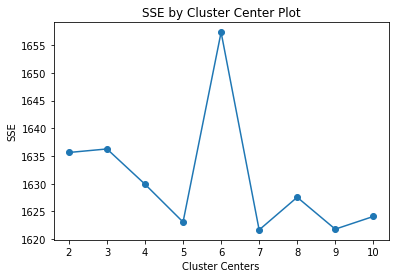

In [107]:
k_means(Information_Technology_Group, 4)

In [20]:
BFS = content_selection('BUSINESS & FINANCIAL SERVICES')

Business Support Services              1039
Financial Institutions and Services     322
Construction and Civil Engineering      110
Wholesale Trade and Shipping             50
Name: IndustrySegment, dtype: int64


/Users/weiding/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Fit 2 clusters
Fit 3 clusters
Fit 4 clusters
Fit 5 clusters
Fit 6 clusters
Fit 7 clusters
Fit 8 clusters
Fit 9 clusters
Fit 10 clusters

Suggested number of group is 9:

Cluster 0
twitter,social,dashboard,id,search,local,fjs,seo,rio,js

Cluster 1
care,underwriting,management,health,information,business,coverage,services,claims,insurance

Cluster 2
names,registration,registrar,email,site,godaddy,daddy,domains,information,domain

Cluster 3
policy,content,website,services,data,personal,privacy,site,use,information

Cluster 4
management,company,time,new,service,use,data,business,services,information

Cluster 5
managers,inputs,production,treatments,base,practice,dentistry,dental,patient,dentists

Cluster 6
business,new,service,hr,services,information,tax,clients,evolution,payroll

Cluster 7
help,web,solutions,website,services,business,data,hosting,wordpress,cloud

Cluster 8
quarter,chief,president,small,business,served,mr,group,international,endurance
Counter({4: 1199, 3: 184, 7: 72, 1: 44,

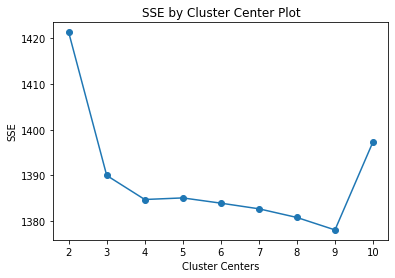

In [108]:
k_means(BFS, 4)

In [21]:
HG = content_selection('HEALTHCARE GROUP')

Biopharmaceuticals                           353
Medical Devices and Equipment                302
Healthcare Services                          183
Medical Software and Information Services    162
Name: IndustrySegment, dtype: int64


/Users/weiding/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Fit 2 clusters
Fit 3 clusters
Fit 4 clusters
Fit 5 clusters
Fit 6 clusters
Fit 7 clusters
Fit 8 clusters
Fit 9 clusters
Fit 10 clusters

Suggested number of group is 7:

Cluster 0
company,products,com,services,web,medical,website,site,use,information

Cluster 1
tri,ridge,group,tort,charlotte,mass,cincinnati,resolution,settlement,grg

Cluster 2
served,mr,research,company,therapeutics,clinical,development,university,dr,cancer

Cluster 3
data,home,services,medical,patients,information,patient,healthcare,health,care

Cluster 4
visibility,catch,cta,getelementsbytagname,ehr,el,err,document,razorinsights,hsjs

Cluster 5
qc,nm,com,ph,ss,vs,kg,gb,mg,english

Cluster 6
amazon,sites,plugins,beautiful,themes,hosting,website,theme,plesk,wordpress
Counter({0: 697, 2: 154, 3: 130, 6: 16, 1: 1, 5: 1, 4: 1})
--------------------------------------------------

The actual number of group should be 4:

Cluster 0
data,products,com,services,web,medical,website,site,use,information

Cluster 1
sc,estate,progr

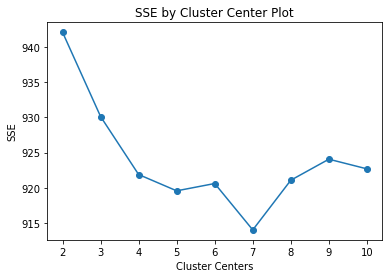

In [109]:
k_means(HG, 4)

In [22]:
CSG = content_selection('CONSUMER SERVICES GROUP')

/Users/weiding/opt/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:294: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


Consumer Information Services    407
Media and Content                261
Travel and Leisure               220
Retailers                        201
Name: IndustrySegment, dtype: int64


/Users/weiding/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Fit 2 clusters
Fit 3 clusters
Fit 4 clusters
Fit 5 clusters
Fit 6 clusters
Fit 7 clusters
Fit 8 clusters
Fit 9 clusters
Fit 10 clusters

Suggested number of group is 8:

Cluster 0
cruise,cruises,river,travelers,trip,tours,tour,trips,stride,travel

Cluster 1
personal,privacy,content,website,terms,service,site,services,use,information

Cluster 2
investment,fleet,instructors,place,funding,business,training,driving,instructor,red

Cluster 3
chicago,information,catering,site,beef,llc,hot,theme,dogs,il

Cluster 4
content,powhow,yahoo,team,creators,videos,live,streaming,rdf,video

Cluster 5
corp,parkway,com,gourmet,va,la,chocolate,foods,source,candy

Cluster 6
business,like,services,site,service,com,time,use,new,information

Cluster 7
teaching,use,information,university,college,student,school,learning,education,students
Counter({6: 722, 1: 307, 7: 48, 4: 8, 2: 1, 3: 1, 0: 1, 5: 1})
--------------------------------------------------

The actual number of group should be 4:

Cluster 0
creators,

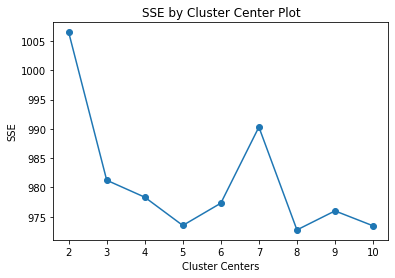

In [110]:
k_means(CSG, 4)

In [23]:
EUG = content_selection('ENERGY & UTILITIES GROUP')

Renewable Energy        98
Non-Renewable Energy    96
Utilities               16
Name: IndustrySegment, dtype: int64


/Users/weiding/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Fit 2 clusters
Fit 3 clusters
Fit 4 clusters
Fit 5 clusters
Fit 6 clusters
Fit 7 clusters
Fit 8 clusters
Fit 9 clusters
Fit 10 clusters

Suggested number of group is 8:

Cluster 0
site,use,gas,technology,water,wind,fuel,information,power,energy

Cluster 1
menu,gt,enphase,panels,pv,civicsolar,junction,power,energy,solar

Cluster 2
terms,offshore,statement,use,information,website,eb,etagen,ihc,seajacks

Cluster 3
world,twitter,hootsuite,solar,hood,robin,brighter,energy,argand,vio

Cluster 4
quarter,prospectus,statements,basin,proxy,transaction,sec,permian,concho,rsp

Cluster 5
drilling,basin,company,texas,midstream,exploration,mr,gas,energy,oil

Cluster 6
instance,gandi,les,det,og,islas,en,et,er,du

Cluster 7
information,microsoft,bit,drilling,aol,fidelity,archer,reamco,memorial,rss
Counter({0: 137, 5: 39, 1: 20, 7: 5, 3: 3, 2: 3, 6: 2, 4: 1})
--------------------------------------------------

The actual number of group should be 3:

Cluster 0
enphase,civicsolar,information,junction,sol

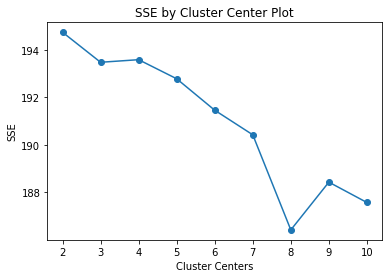

In [111]:
k_means(EUG, 3)